In [2]:
# I am not sure I entirely understand the given methods. So in Verma and Lewis method
# we go through every single row and see how a bit flip would affect it.
# But we do not multiply the quadratic coefficients by 2. 
# In examples the quadratic coefficients are always twice smaller in a 
# QUBO row as there will be another instance of the same coefficient, just in a different row.
# So 6x1x6 will be a 3 in row 1 and a 3 in row 6, but when they are added together, they will make a 6.

In [14]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import neal
import greedy
import tabu
import matplotlib.pyplot as plt

import sys
from pathlib import Path
current_path = Path().resolve()
sys.path.append(str(current_path / '../Data/Multidimensional Knapsack'))
from util import *

from IPython.display import display_html
from itertools import chain, cycle

import time
import pickle

# Load data

In [4]:
data_folder = '../data/Multidimensional Knapsack/'
# Both Weish and WEING problems are just problems. There is no 
# difference between them, just more instances
# We have Weish[01-30] files in Weish folder
weish_files_no = 30
weish_file_paths = ['weish//Weish'+ str(i).zfill(2) +'.npz' for i in range(1, weish_files_no + 1)]
weish_loaded_files = [np.load(data_folder + i) for i in weish_file_paths]
# We have WEING[1-8] files in Weing folder
weing_files_no = 8
weing_file_paths = ['weing//WEING'+ str(i) +'.npz' for i in range(1, weing_files_no + 1)]
weing_loaded_files = [np.load(data_folder + i) for i in weing_file_paths]
loaded_files = weish_loaded_files + weing_loaded_files
qubo_sizes = [i['n'] for i in loaded_files]
objectives = [i['objective'] for i in loaded_files]
constraints = [i['constraint'] for i in loaded_files]

# Custom Methods

In [5]:
def convert_1d_qubo_to_2d(qubo, n):
    if (len(qubo)!= (n) * ((n+1) * 0.5)   + 1):
        print('check that n is the correct size')
        return None, None
    constant = qubo[0]
    linear_terms = np.array(qubo[1:(n + 1)])
    no_of_quadratic_terms = len(qubo) - len(linear_terms) -1
    quadratic_terms = np.array(qubo[-no_of_quadratic_terms:])
    k = 0
    qubo_coeffs = []
    for i in range(n):
        coeffs = []
        for j in range(n):
            if(i == j):
                coeffs.append(linear_terms[i])
            elif(j>i):
                coeffs.append(quadratic_terms[k])
                k+=1
            else:
                coeffs.append(0)
        qubo_coeffs.append(coeffs)
    qubo_coeffs = np.array(qubo_coeffs)

    return qubo_coeffs, constant

In [6]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align:left">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# Prepare data

In [7]:
obj_qubos, obj_constants, con_qubos, con_constants = [], [], [], []

for i in range(len(qubo_sizes)):
    obj = convert_1d_qubo_to_2d(objectives[i], qubo_sizes[i])
    const = convert_1d_qubo_to_2d(constraints[i], qubo_sizes[i])
    obj_qubos.append(obj[0])
    obj_constants.append(obj[1])
    con_qubos.append(const[0])
    con_constants.append(const[1])

In [8]:
print('constant term and QUBO matrix representing the cost (unconstrained objective) function' )
print(obj_constants[0], obj_qubos[0])
print('constant term and QUBO matrix representing the constraint function' )
print(con_constants[0], con_qubos[0])

constant term and QUBO matrix representing the cost (unconstrained objective) function
0 [[360   0   0 ...   0   0   0]
 [  0  83   0 ...   0   0   0]
 [  0   0  59 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
constant term and QUBO matrix representing the constraint function
1298080 [[127183  19348  17556 ...   -752   -376   -188]
 [     0 272396  39720 ...   -688   -344   -172]
 [     0      0 324856 ...   -640   -320   -160]
 ...
 [     0      0      0 ...  -3376     16      8]
 [     0      0      0 ...      0  -1692      4]
 [     0      0      0 ...      0      0   -847]]


In [57]:
######## QUBO you need to solve ########
# TODO check if verma and lewis penalty is doing everything as expected
penalties = [util.verma_penalty(i) for i in obj_qubos]
print('penalties', penalties)
#QUBO matrix 
Qs = [-1*obj_qubo + penalty * con_qubo for obj_qubo, penalty, con_qubo in zip(obj_qubos, penalties, con_qubos)]
#constant term
cs = [-1*obj_constant+ penalty * con_constant for obj_constant, penalty, con_constant in zip(obj_constants, penalties, con_constants)]

penalties [1.053128689492326, 10.25287356321839, 0.35751503006012025, 1.6307129798903108, 0.3546719681908549, 0.514121037463977, 0.5262536873156343, 0.5262536873156343, 0.40270880361173816, 0.8146118721461187, 0.6487272727272727, 0.8146118721461187, 0.8146118721461187, 2.258227848101266, 1.0682634730538922, 0.6888030888030888, 0.27269948028125957, 0.29429231276806334, 0.25261965448881335, 6.96875, 6.96875, 0.3157522123893805, 0.31959871013973484, 0.40712003651300777, 0.23529411764705882, 0.40712003651300777, 0.40712003651300777, 0.40712003651300777, 0.40712003651300777, 1.1276864728192162, 36.36363636363637, 29.41738299904489, 21.28541810642709, 36.36363636363637, 36.36363636363637, 33.36944745395449, 48.92743039707896, 14.907523293005145]


In [58]:
#change QUBO matrix to the dwave format
newQs = [util.convert_QUBO_to_dwave_format(Q) for Q in Qs]
# Solve every QUBO 10 times with a different seed
# But remember to start with 1 as simulated annealing does not work with seed=0
repeats = 10

## Greedy

In [59]:
#run solver
sampler = greedy.SteepestDescentSampler()

# Format {seed : [objective_energies, constraint_energies]}
greedy_runs = {}

# TODO using seeds is kind of pointless as we 
# TODO same budget as SA, keep seeds
for seed in range(1, repeats + 1):
    clear_output(wait=True)
    # Solve every QUBO
    greedy_objs = []
    greedy_cons = []
    for problem_num in range(len(newQs)):

        response =  sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=100)

        #print("samples=" + str(list(response.samples())))
        #print("energies=" + str(list(response.data_vectors['energy'])) )

        solution = list(response.samples())[-1]

        y = np.array([int(solution[i]) for i in range(len(solution))])
        #print(y)
        
        # Even though we have multiplied the objective function by -1 to 
        # transfer it to minimisation problem when defining a QUBO,
        # we do not need to multiply it by -1 again as we are using the original 
        # objective function here.
        # So here we will have the original objective function value.
        obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
        # The constraint function before multiplying it by penalty coefficient
        con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
        greedy_objs.append(obj)
        greedy_cons.append(con)

        #print('The objective function value of x is ',obj )
        #print('The constraint function value of x is ',con )
    
    greedy_runs[seed] = (greedy_objs, greedy_cons)
    print(np.round(seed/repeats * 100, 2), '%')

100.0 %


## Simulated Annealing

In [60]:
# TODO use numreads instead of seed
#run solver
sampler = neal.SimulatedAnnealingSampler()

sa_runs = {}

for seed in range(1, repeats+1):
    clear_output(wait=True)
    # Solve every QUBO
    sa_objs = []
    sa_cons = []
    for problem_num in range(len(newQs)):
        response =  sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=10)

        #print("samples=" + str(list(response.samples())))
        #print("energies=" + str(list(response.data_vectors['energy'])) )

        solution = list(response.samples())[-1]

        y = np.array([int(solution[i]) for i in range(len(solution))])
        #print(y)

        obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
        con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
        sa_objs.append(obj)
        sa_cons.append(con)

        #print('The objective function value of x is ',obj )
        #print('The constraint function value of x is ',con )
    sa_runs[seed] = (sa_objs, sa_cons)
    print(np.round(seed/repeats * 100, 2), '%')

100.0 %


## Tabu

In [61]:
#run solver
sampler = tabu.TabuSampler()

# Hyperparameters
timeout = 20 # default 20

tabu_runs = {}

# TODO numreads instead of seeds
for seed in range(1, repeats+1):
    clear_output(wait=True)
    # Solve every QUBO
    tabu_objs = []
    tabu_cons = []
    for problem_num in range(len(newQs)):

        response =  sampler.sample_qubo(newQs[problem_num], seed = seed, timeout=timeout)

        #print("samples=" + str(list(response.samples())))
        #print("energies=" + str(list(response.data_vectors['energy'])) )

        solution = list(response.samples())[-1]

        y = np.array([int(solution[i]) for i in range(len(solution))])
        #print(y)

        obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
        con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
        tabu_objs.append(obj)
        tabu_cons.append(con)

        #print('The objective function value of x is ',obj )
        #print('The constraint function value of x is ',con )
    tabu_runs[seed] = (tabu_objs, tabu_cons)
    print(np.round(seed/repeats * 100, 2), '%')

100.0 %


## Record the results

In [62]:
greedy_results = []
sa_results = []
tabu_results = []

for i in range(1, repeats + 1):
    
    # 1: QUBO size, 2: penalty coeffficient, 3: objective function energy 
    # 4: constraint function energy (without taking into account penalty coefficient), 
    # 5: total QUBO energy (since we are transfering maximisation problem to minimisation,
    # we need to take the negative of objective function).
    # Energy should be negative if no constraints were broken as we will be the negative of objective
    # function and adding it to the constraint function.
    greedy_results_local = pd.DataFrame({'Size' : qubo_sizes, 
                                 'Penalty' : penalties, 
                                 'Objective Function' : greedy_runs[i][0], 
                                 'Broken Constraints' : greedy_runs[i][1],
                                 'Energy (minimisation)' : [-list1+list2*penalty for list1, list2, penalty in zip(greedy_runs[i][0], greedy_runs[i][1], penalties)]})

    sa_results_local = pd.DataFrame({'Size' : qubo_sizes, 
                                 'Penalty' : penalties, 
                                 'Objective Function' : sa_runs[i][0], 
                                 'Broken Constraints' : sa_runs[i][1],
                                 'Energy (minimisation)' : [-list1+list2*penalty for list1, list2, penalty in zip(sa_runs[i][0], sa_runs[i][1], penalties)]})

    tabu_results_local = pd.DataFrame({'Size' : qubo_sizes, 
                                 'Penalty' : penalties, 
                                 'Objective Function' : tabu_runs[i][0], 
                                 'Broken Constraints' : tabu_runs[i][1],
                                 'Energy (minimisation)' : [-list1+list2*penalty for list1, list2, penalty in zip(tabu_runs[i][0], tabu_runs[i][1], penalties)]})

    greedy_results.append(greedy_results_local)
    sa_results.append(sa_results_local)
    tabu_results.append(tabu_results_local)
    
# Display the first repetition table
rep = 9
display_side_by_side(greedy_results[rep], sa_results[rep], tabu_results[rep], titles=['Greedy', 'SA', 'Tabu'])

,Size,Penalty,Objective Function,Broken Constraints,Energy (minimisation)
0,85,1.053129,1709,25526,25173.162928
1,85,10.252874,3016,17537,176788.643678
2,90,0.357515,3522,44150,12262.288577
3,85,1.630713,3804,18140,25777.133455
4,90,0.354672,2172,23043,6000.706163
5,100,0.514121,3762,34583,14017.847839
6,100,0.526254,3126,25587,10339.253097
7,100,0.526254,5368,26379,8514.046018
8,100,0.402709,2649,26246,7920.495260
9,110,0.814612,3630,89475,69257.397260


## Analyse results

In [63]:
# Show total energies of all tries in all problems in a single df
energies_greedy = pd.DataFrame()
energies_sa = pd.DataFrame()
energies_tabu = pd.DataFrame()
for i in range(repeats):
    energies_greedy[f'Energy (minimisation) {i}'] = greedy_results[i]['Energy (minimisation)']
    energies_sa[f'Energy (minimisation) {i}'] = sa_results[i]['Energy (minimisation)']
    energies_tabu[f'Energy (minimisation) {i}'] = tabu_results[i]['Energy (minimisation)']

energies_greedy

,Energy (minimisation) 0,Energy (minimisation) 1,Energy (minimisation) 2,Energy (minimisation) 3,Energy (minimisation) 4,Energy (minimisation) 5,Energy (minimisation) 6,Energy (minimisation) 7,Energy (minimisation) 8,Energy (minimisation) 9
0,2.141781e+04,2.248393e+04,21409.357733,20361.654073,4.109123e+04,16296.897285,15416.735537,37776.832349,24077.598583,25173.162928
1,1.947578e+05,4.741157e+05,361007.942529,241788.436782,3.307522e+05,155314.045977,264771.356322,187764.172414,211876.850575,176788.643678
2,6.002679e+04,1.366132e+04,13733.415631,15225.412024,1.344443e+04,3599.519038,14120.822044,13453.589579,5502.101804,12262.288577
3,2.914954e+04,2.339209e+04,36242.076782,16268.625229,4.512912e+04,21677.420475,18699.065814,43809.875686,24649.263254,25777.133455
4,3.180815e+04,4.555945e+03,11301.535984,19167.871571,1.701739e+04,4805.576541,20723.532406,2382.955070,4606.001988,6000.706163
5,5.038502e+03,2.097241e+04,3580.308934,6622.926801,1.088838e+04,12178.220749,11745.567723,8918.742363,15100.444957,14017.847839
6,1.109052e+04,4.340525e+04,15814.536283,18396.278466,7.543628e+03,10009.774631,41283.155162,15264.673156,11924.244838,10339.253097
7,1.797851e+04,4.072193e+04,16534.772271,9696.868437,7.520743e+03,13047.586431,31984.993510,35876.741593,25132.430678,8514.046018
8,1.074691e+04,1.305664e+04,7330.739955,8474.745372,9.100613e+03,10461.579233,5232.400451,11383.027991,5822.152596,7920.495260
9,5.798650e+04,1.107084e+05,86476.966210,70432.638356,1.005327e+05,91480.014612,83568.019178,60322.085845,52943.160731,69257.397260


In [214]:
# Show feasible solutions
feasible_full_greedy = pd.DataFrame()
feasible_full_sa = pd.DataFrame()
feasible_full_tabu = pd.DataFrame()
for i in range(repeats):
    feasible_full_greedy[f'Feasible {i}'] = greedy_results[i]['Broken Constraints'] == 0
    feasible_full_sa[f'Feasible {i}'] = sa_results[i]['Broken Constraints'] == 0
    feasible_full_tabu[f'Feasible {i}'] = tabu_results[i]['Broken Constraints'] == 0

feasible_full_tabu

,Feasible 0,Feasible 1,Feasible 2,Feasible 3,Feasible 4,Feasible 5,Feasible 6,Feasible 7,Feasible 8,Feasible 9
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False


In [206]:
# Calculate number of feasible solutions (in all runs)
feasible_greedy = pd.DataFrame({'Feasible' : feasible_full_greedy.sum(axis=1)})
feasible_sa = pd.DataFrame({'Feasible' : feasible_full_sa.sum(axis=1)})
feasible_tabu = pd.DataFrame({'Feasible' : feasible_full_tabu.sum(axis=1)})
# Calculate feasibility rate
feasible_greedy['Feasibility rate'] = feasible_greedy['Feasible'] / repeats
feasible_sa['Feasibility rate'] = feasible_sa['Feasible'] / repeats
feasible_tabu['Feasibility rate'] = feasible_tabu['Feasible'] / repeats
# Calculate mean energy
feasible_greedy['Mean energy'] = energies_greedy.mean(axis=1)
feasible_sa['Mean energy'] = energies_sa.mean(axis=1)
feasible_tabu['Mean energy'] = energies_tabu.mean(axis=1)
# Calculate energy standard deviation
feasible_greedy['SD energy'] = energies_greedy.std(axis=1)
feasible_sa['SD energy'] = energies_sa.std(axis=1)
feasible_tabu['SD energy'] = energies_tabu.std(axis=1)
# Calculate total row
feasible_greedy.loc['Total'] = feasible_greedy.sum()
feasible_sa.loc['Total'] = feasible_sa.sum()
feasible_tabu.loc['Total'] = feasible_tabu.sum()
# Calculate mean row
feasible_greedy.loc['Mean'] = feasible_greedy.mean()
feasible_sa.loc['Mean'] = feasible_sa.mean()
feasible_tabu.loc['Mean'] = feasible_tabu.mean()
# Calculate SD row
feasible_greedy.loc['SD'] = feasible_greedy.std()
feasible_sa.loc['SD'] = feasible_sa.std()
feasible_tabu.loc['SD'] = feasible_tabu.std()

# Display the table
display_side_by_side(feasible_greedy, feasible_sa, feasible_tabu, titles=['Greedy', 'SA', 'Tabu'])

,Feasible,Feasibility rate,Mean energy,SD energy
0,0.0,0.0,2.340843e+07,7.244773e+06
1,0.0,0.0,2.286454e+07,8.745077e+06
2,0.0,0.0,4.960288e+07,3.822474e+07
3,0.0,0.0,1.735061e+07,5.874920e+06
4,0.0,0.0,3.865962e+07,2.640903e+07
5,0.0,0.0,2.418310e+07,8.842508e+06
6,0.0,0.0,3.575671e+07,2.182362e+07
7,0.0,0.0,4.059702e+07,1.899814e+07
8,0.0,0.0,2.783214e+07,6.133941e+06
9,0.0,0.0,9.069000e+07,2.114540e+07


In [215]:
# Calculate number of feasible solutions (in all runs)
feasible_greedy = pd.DataFrame({'Feasible' : feasible_full_greedy.sum(axis=1)})
feasible_sa = pd.DataFrame({'Feasible' : feasible_full_sa.sum(axis=1)})
feasible_tabu = pd.DataFrame({'Feasible' : feasible_full_tabu.sum(axis=1)})
# Calculate feasibility rate
feasible_greedy['Feasibility rate'] = feasible_greedy['Feasible'] / repeats
feasible_sa['Feasibility rate'] = feasible_sa['Feasible'] / repeats
feasible_tabu['Feasibility rate'] = feasible_tabu['Feasible'] / repeats
# Calculate mean energy
feasible_greedy['Mean energy'] = energies_greedy.mean(axis=1)
feasible_sa['Mean energy'] = energies_sa.mean(axis=1)
feasible_tabu['Mean energy'] = energies_tabu.mean(axis=1)
# Calculate energy standard deviation
feasible_greedy['SD energy'] = energies_greedy.std(axis=1)
feasible_sa['SD energy'] = energies_sa.std(axis=1)
feasible_tabu['SD energy'] = energies_tabu.std(axis=1)
# Calculate total row
feasible_greedy.loc['Total'] = feasible_greedy.sum()
feasible_sa.loc['Total'] = feasible_sa.sum()
feasible_tabu.loc['Total'] = feasible_tabu.sum()
# Calculate mean row
feasible_greedy.loc['Mean'] = feasible_greedy.mean()
feasible_sa.loc['Mean'] = feasible_sa.mean()
feasible_tabu.loc['Mean'] = feasible_tabu.mean()
# Calculate SD row
feasible_greedy.loc['SD'] = feasible_greedy.std()
feasible_sa.loc['SD'] = feasible_sa.std()
feasible_tabu.loc['SD'] = feasible_tabu.std()

# Display the table
display_side_by_side(feasible_greedy, feasible_sa, feasible_tabu, titles=['Greedy', 'SA', 'Tabu'])

,Feasible,Feasibility rate,Mean energy,SD energy
0,0.0,0.0,2.367109e+07,7.149206e+06
1,0.0,0.0,2.292409e+07,8.677865e+06
2,0.0,0.0,5.002694e+07,3.881689e+07
3,0.0,0.0,1.736385e+07,5.860640e+06
4,0.0,0.0,4.062924e+07,2.509955e+07
5,0.0,0.0,2.539824e+07,7.844149e+06
6,0.0,0.0,3.585175e+07,2.180330e+07
7,0.0,0.0,3.938021e+07,1.974375e+07
8,0.0,0.0,2.847210e+07,5.690859e+06
9,0.0,0.0,9.135165e+07,1.952550e+07


# Run Length Distribution

## Greedy

In [96]:
#run solver
sampler = greedy.SteepestDescentSampler()

# Solve QUBO a lot of times
problem_num = 25
seed = 0
response =  sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=100000)

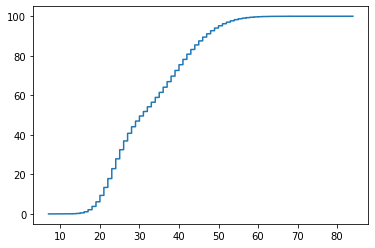

In [97]:
x = []
y = []

for steps, energy in response.data(fields=['num_steps', 'energy'], sorted_by='num_steps'):
    x.append(steps)
    y.append(energy)

# Sort both lists by x
x, y = (list(t) for t in zip(*sorted(zip(x, y))))
    
# Our target is the mean energy that Verma and Lewis penalty produces
target = (sum(y)/len(y))

cumulative_y = [i < target for i in y]
cumulative_y_percentage = (np.cumsum(cumulative_y)/sum(cumulative_y))*100

plt.plot(x, cumulative_y_percentage)

## Tabu

In [99]:
#run solver
sampler = tabu.TabuSampler()

x = []
y = []

# Hyperparameters
timeout = 10 # default 20
problem_num = 25
# num restarts has to be 1 (Towards a Characterisation of the Behaviour of Stochastic Local Search Algorithms for SAT)
for seed in range(1, 1000):
    start = time.time()
    response =  sampler.sample_qubo(newQs[problem_num], seed = seed, timeout=timeout, num_reads=1, num_restarts=1)
    end = time.time()
    x.append(end - start)
    data = response.data(fields=['energy'])
    energy = next(data).energy
    y.append(energy)
    

In [100]:
# Sort both lists by x
x, y = (list(t) for t in zip(*sorted(zip(x, y))))

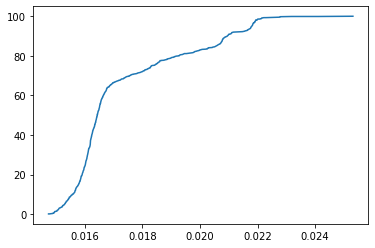

In [101]:
# Our target is the mean energy that Verma and Lewis penalty produces
target = (sum(y)/len(y))

cumulative_y = [i < target for i in y]
cumulative_y_percentage = (np.cumsum(cumulative_y)/sum(cumulative_y))*100

plt.plot(x, cumulative_y_percentage)

# Save results

In [ ]:
# TODO proper saving

In [41]:
data_folder = '../Data/Produced/'

In [42]:
# TODO add other algorithms

In [46]:
energies_sa.to_pickle(data_folder + 'sa_energies_new.pkl')

In [43]:
with open(data_folder + 'sa_energies_new.p', 'wb') as f:
    pickle.dump(energies_sa, f)

# Statistical significance

In [64]:
new_energies_sa = energies_sa

In [56]:
old_energies_sa = energies_sa

In [73]:
new_energies_sa

,Energy (minimisation) 0,Energy (minimisation) 1,Energy (minimisation) 2,Energy (minimisation) 3,Energy (minimisation) 4,Energy (minimisation) 5,Energy (minimisation) 6,Energy (minimisation) 7,Energy (minimisation) 8,Energy (minimisation) 9
0,-902.131051,-2141.590319,-836.791027,-1068.257379,-1763.874852,-1475.377804,-2112.100354,-1874.971665,-1281.590319,-2218.397875
1,4730.862069,6060.804598,10192.367816,12637.517241,11076.678161,20567.862069,8396.643678,6560.149425,6507.333333,1848.620690
2,-3217.507014,-2810.909419,-2584.046493,-2754.056112,-988.062926,-2875.351102,-2457.103407,-1848.045691,-2413.351904,-2306.849699
3,-1130.404022,-777.937843,-1236.188300,-1358.720293,-641.279707,-738.703839,-1378.826325,-930.756856,-673.583181,206.925046
4,-2409.998012,-3166.764215,-2964.873161,-1693.217893,-3317.784891,-2295.336382,-2389.109344,-2490.290258,-2623.191650,-2377.018688
5,-3295.432277,-3832.820749,-2412.000000,-3020.600000,-3442.288184,-2752.375793,-1849.429395,-3060.842075,-3336.577522,-3288.933141
6,-2111.843068,-2157.328024,-3109.797050,-860.437758,-2794.000000,-2546.764602,-2600.558112,-3585.919764,-3072.844838,-1968.474926
7,-2943.143953,-3766.274336,-3971.374631,-3570.353982,-3190.282596,-1675.234218,-2947.894985,-3378.329204,-3094.434218,-2687.184071
8,-2907.792325,-3346.986907,-2091.544470,-2853.242889,-3289.448758,-2376.260045,-3725.064560,-2736.237923,980.685327,-2590.589165
9,-3038.496804,-3362.469406,-3165.136986,6979.304110,3475.221005,21242.445662,-3942.113242,-3099.084932,-3322.638356,-3168.582648


In [72]:
old_energies_sa

,Energy (minimisation) 0,Energy (minimisation) 1,Energy (minimisation) 2,Energy (minimisation) 3,Energy (minimisation) 4,Energy (minimisation) 5,Energy (minimisation) 6,Energy (minimisation) 7,Energy (minimisation) 8,Energy (minimisation) 9
0,1064359,930121,1282321,1342006,1745001,1872304,401959,1513352,748674,1228315
1,809123,636792,670356,1078623,550992,613876,934243,2071094,771698,979706
2,777682,814551,1157031,834678,1450204,536447,1649108,1695865,1298578,1459087
3,1269897,2492120,1262772,1655733,1025376,1642915,884698,835206,1614714,1366486
4,1201929,967255,2780615,1811292,1851426,1295248,989566,988282,1712814,1254057
5,1610191,1322709,805087,1236329,1448591,596297,1251753,1156860,736642,1006118
6,1697585,1223121,1780338,965930,861754,1215579,665063,1191297,1122931,599638
7,1052120,1175272,947556,891776,667456,1108824,899728,1240618,855547,1200478
8,2044134,1259946,1285652,786684,1168741,1191944,1949622,1748498,1156574,1081028
9,1010243,1992693,1535954,1428919,1372386,1351293,1565095,1721470,1564152,1339040


In [65]:
import scipy.stats as stats

In [69]:
new_energies_sa.iloc[0]

Energy (minimisation) 0    -902.131051
Energy (minimisation) 1   -2141.590319
Energy (minimisation) 2    -836.791027
Energy (minimisation) 3   -1068.257379
Energy (minimisation) 4   -1763.874852
Energy (minimisation) 5   -1475.377804
Energy (minimisation) 6   -2112.100354
Energy (minimisation) 7   -1874.971665
Energy (minimisation) 8   -1281.590319
Energy (minimisation) 9   -2218.397875
Name: 0, dtype: float64

In [71]:
old_energies_sa.iloc[0]

Energy (minimisation) 0    1064359
Energy (minimisation) 1     930121
Energy (minimisation) 2    1282321
Energy (minimisation) 3    1342006
Energy (minimisation) 4    1745001
Energy (minimisation) 5    1872304
Energy (minimisation) 6     401959
Energy (minimisation) 7    1513352
Energy (minimisation) 8     748674
Energy (minimisation) 9    1228315
Name: 0, dtype: int64

In [70]:
stats.ttest_ind(new_energies_sa.iloc[0], old_energies_sa.iloc[0])

Ttest_indResult(statistic=-8.575018150805937, pvalue=8.994725044770677e-08)

# new

In [153]:
def verma_penalty(qubo_obj):
        weights = np.zeros(shape = (len(qubo_obj) * 2), dtype='int64')
        k = 0
        for i in range(len(qubo_obj)):
            weights[k]= qubo_obj[i][i]
            weights[k+1]= -qubo_obj[i][i]
            for j in range(len(qubo_obj)):
                if(i!=j):
                    if(qubo_obj[i][j] > 0):
                        weights[k]+= qubo_obj[i][j]
                    else:
                        weights[k+1]-=qubo_obj[i][j]
            k = k+2
        return min(weights)

In [32]:
def new_penalty(qubo_obj, con_obj):
        weights_obj = np.zeros(shape = (len(qubo_obj) * 2), dtype='int64')
        k = 0
        
        for i in range(len(qubo_obj)):
            weights_obj[k]= qubo_obj[i][i]
            weights_obj[k+1]= -qubo_obj[i][i]
            for j in range(len(qubo_obj)):
                if(i!=j):
                    if(qubo_obj[i][j] > 0):
                        weights_obj[k]+= qubo_obj[i][j]
                    else:
                        weights_obj[k+1]-=qubo_obj[i][j]
            k = k+2
            
        weights_con = np.zeros(shape = (len(con_obj) * 2), dtype='int64')
        k = 0
        
        for i in range(len(con_obj)):
            weights_con[k]= con_obj[i][i]
            weights_con[k+1]= -con_obj[i][i]
            for j in range(len(con_obj)):
                if(i!=j):
                    if(con_obj[i][j] > 0):
                        weights_con[k]+= con_obj[i][j]
                    else:
                        weights_con[k+1]-=con_obj[i][j]
            k = k+2
        
        return max(weights_obj)/min(weights_con[weights_con > 0])

In [160]:
con_qubos

[array([[127183,  19348,  17556, ...,   -752,   -376,   -188],
        [     0, 272396,  39720, ...,   -688,   -344,   -172],
        [     0,      0, 324856, ...,   -640,   -320,   -160],
        ...,
        [     0,      0,      0, ...,  -3376,     16,      8],
        [     0,      0,      0, ...,      0,  -1692,      4],
        [     0,      0,      0, ...,      0,      0,   -847]]),
 array([[ 58723,  19348,  17556, ...,   -752,   -376,   -188],
        [     0, 181676,  39720, ...,   -688,   -344,   -172],
        [     0,      0, 261096, ...,   -640,   -320,   -160],
        ...,
        [     0,      0,      0, ...,  -1216,     16,      8],
        [     0,      0,      0, ...,      0,   -612,      4],
        [     0,      0,      0, ...,      0,      0,   -307]]),
 array([[402487,  19348,  17556, ...,   -752,   -376,   -188],
        [     0, 798124,  39720, ...,   -688,   -344,   -172],
        [     0,      0, 864264, ...,   -640,   -320,   -160],
        ...,
        [   

In [162]:
new_penalties = [new_penalty(i, j) for i, j in zip(obj_qubos, con_qubos)]
new_penalties

[1.053128689492326,
 10.25287356321839,
 0.35751503006012025,
 1.6307129798903108,
 0.3546719681908549,
 0.514121037463977,
 0.5262536873156343,
 0.5262536873156343,
 0.40270880361173816,
 0.8146118721461187,
 0.6487272727272727,
 0.8146118721461187,
 0.8146118721461187,
 2.258227848101266,
 1.0682634730538922,
 0.6888030888030888,
 0.27269948028125957,
 0.29429231276806334,
 0.25261965448881335,
 6.96875,
 6.96875,
 0.3157522123893805,
 0.31959871013973484,
 0.40712003651300777,
 0.23529411764705882,
 0.40712003651300777,
 0.40712003651300777,
 0.40712003651300777,
 0.40712003651300777,
 1.1276864728192162,
 36.36363636363637,
 29.41738299904489,
 21.28541810642709,
 36.36363636363637,
 36.36363636363637,
 33.36944745395449,
 48.92743039707896,
 14.907523293005145]

In [163]:
penalties

[892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 30800,
 30800,
 30800,
 30800,
 30800,
 30800,
 107200,
 107200]

In [129]:
new_penalties

[-0.004949396306818182,
 -0.0009306557158119658,
 -0.0008879650866462793,
 -0.0018300288865546219,
 -0.0008367855427473583,
 -0.0010875078027465668,
 -0.0010875078027465668,
 -0.0010875078027465668,
 -0.0009458129750271444,
 -0.00045750722163865546,
 -0.0006481352306547619,
 -0.00045750722163865546,
 -0.00045750722163865546,
 -0.0002636482294188862,
 -0.0003593621080858086,
 -0.0005791846742021277,
 -0.00026428815230582523,
 -0.00020467428336466166,
 -0.0002243930319422978,
 -0.00023416498655913978,
 -0.00023416498655913978,
 -0.00017147514763779528,
 -0.0001670041698619632,
 -0.00011437680540966387,
 -0.00024732928733674046,
 -0.00011437680540966387,
 -0.00011437680540966387,
 -0.00011437680540966387,
 -0.00011437680540966387,
 -6.591205735472155e-05,
 -0.1708984375,
 -0.3612987987987988,
 -0.17641129032258066,
 -0.1708984375,
 -0.1708984375,
 -0.30078125,
 -0.013745732668067227,
 -0.025397258612324114]